In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("spam.csv",encoding_errors='ignore', usecols=['v1','v2'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [5]:
df.rename(columns={"v1": "target",'v2':"text"}, inplace=True)

In [6]:
df.columns

Index(['target', 'text'], dtype='object')

In [7]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.describe()

,target,text
count,5572,5572
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
df.duplicated().sum()

404

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.shape

(5168, 2)

In [13]:
df['target'].value_counts()

target
ham     4516
spam     652
Name: count, dtype: int64

In [14]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [15]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    text = text.lower()                                     
    text = re.sub(r"http\S+|www\S+|\S+@\S+|\d+", "", text)   
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    tokens = word_tokenize(text)                           
    filtered = [stemmer.stem(word) for word in tokens if word not in stop_words]  
    return " ".join(filtered)

In [17]:
df['clean_text'] = df['text'].apply(preprocess_text)
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of Spam vs Ham')

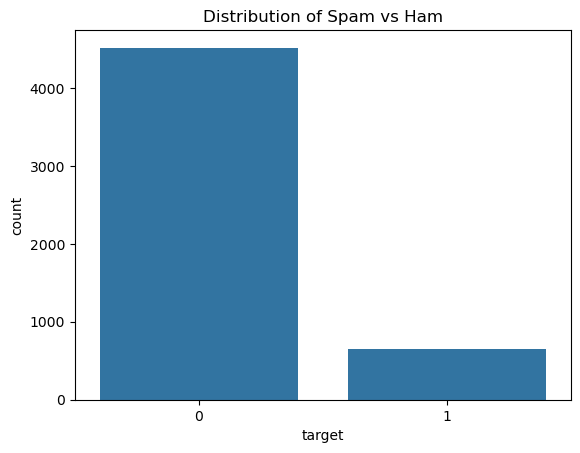

In [106]:
sns.countplot(x='target', data=df)
plt.title("Distribution of Spam vs Ham")

Text(0.5, 1.0, 'Text Length Distribution by Class')

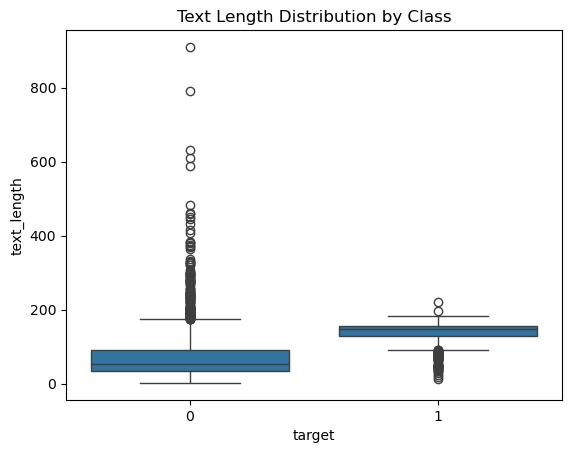

In [110]:
sns.boxplot(x='target', y='text_length', data=df)
plt.title("Text Length Distribution by Class")

Text(0.5, 1.0, 'Word Count with Spam and ham(Not Spam)')

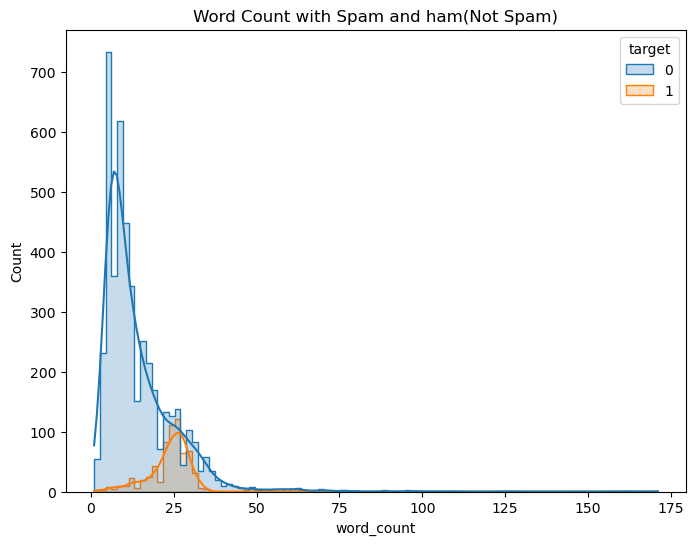

In [118]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='word_count', hue='target', kde=True, element="step")
plt.title("Word Count with Spam and ham(Not Spam)")

Text(0.5, 1.0, 'Relationship between text_length and word_count')

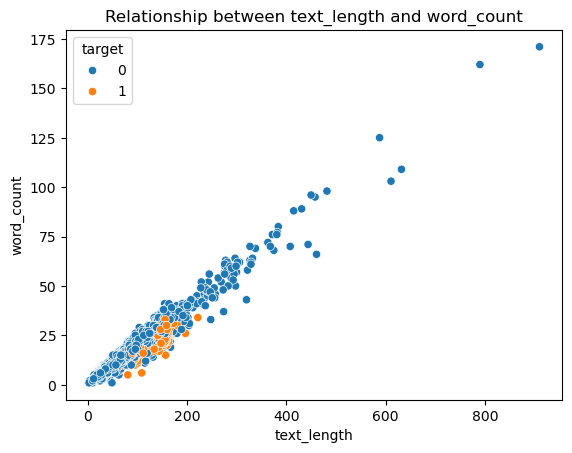

In [126]:
sns.scatterplot(x='text_length', y='word_count', hue='target', data=df)
plt.title("Relationship between text_length and word_count")

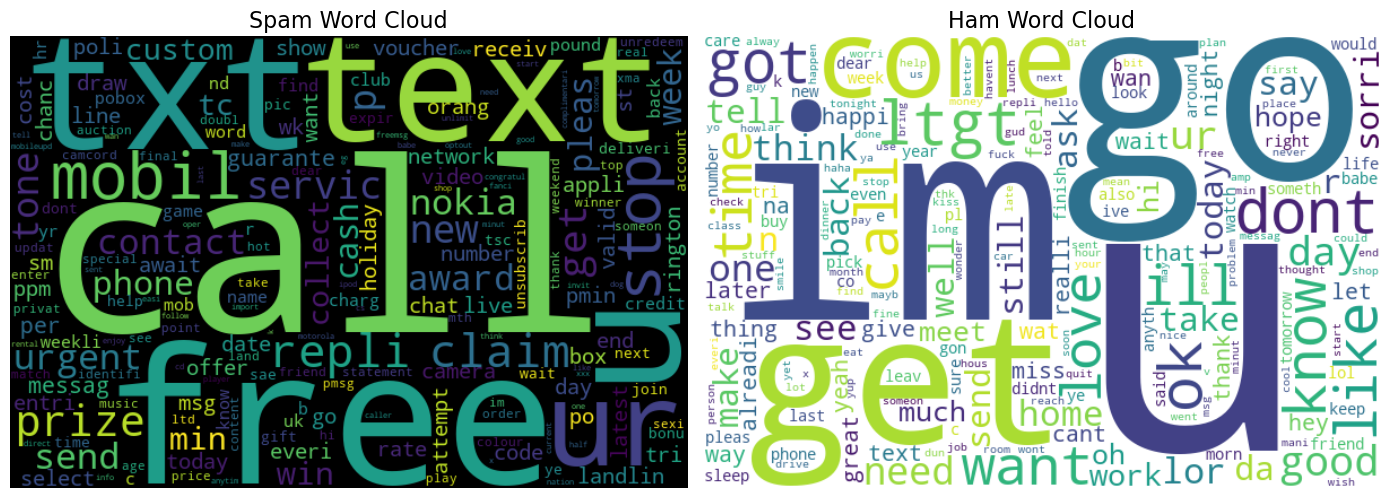

In [156]:
from collections import Counter

spam_words = ' '.join(df[df['target'] == 1]['clean_text']).split()
ham_words = ' '.join(df[df['target'] == 0]['clean_text']).split()

spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)
# Create word clouds
spam_wc = WordCloud(width=600, height=400, background_color='black').generate_from_frequencies(spam_word_freq)
ham_wc = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(ham_word_freq)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Word Cloud', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()

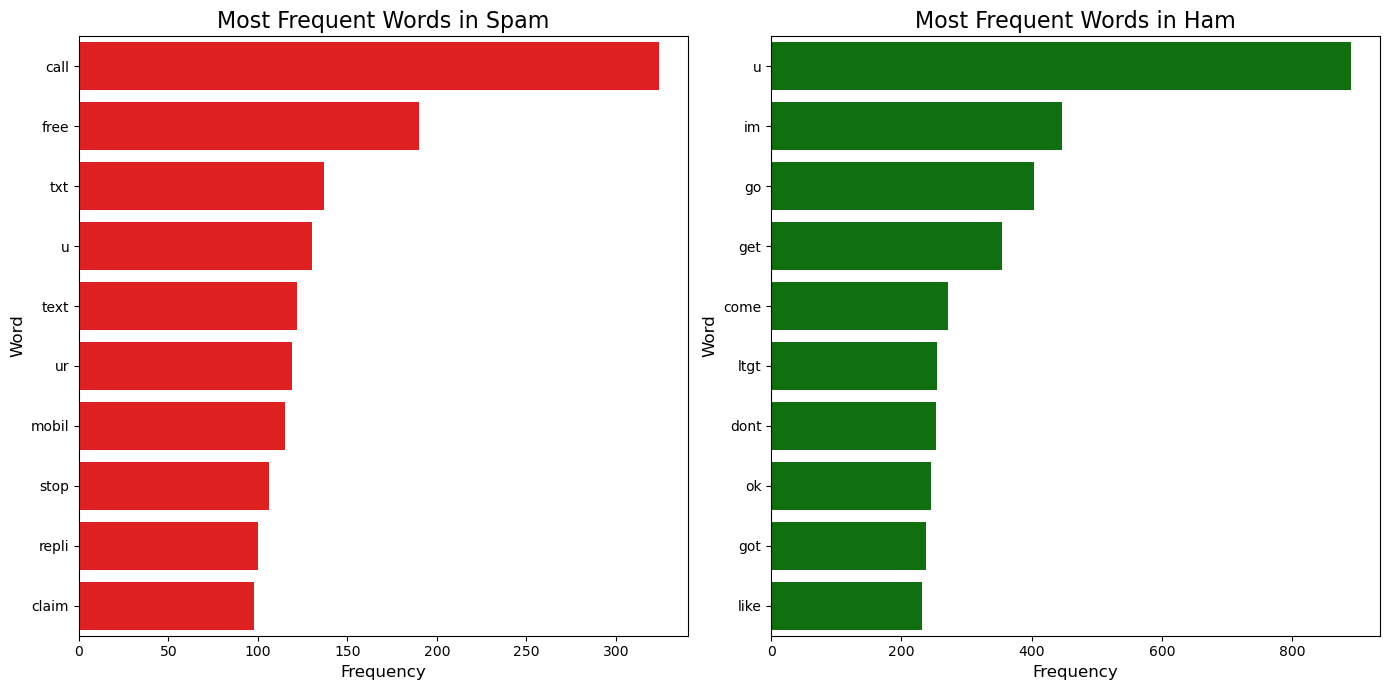

In [160]:
spam_common = spam_word_freq.most_common(10)
ham_common = ham_word_freq.most_common(10)
spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
ham_common_df = pd.DataFrame(ham_common, columns=['Word', 'Frequency'])

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=spam_common_df, color='red')
plt.title('Most Frequent Words in Spam', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=ham_common_df, color='green')
plt.title('Most Frequent Words in Ham', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)

plt.tight_layout()
plt.show()

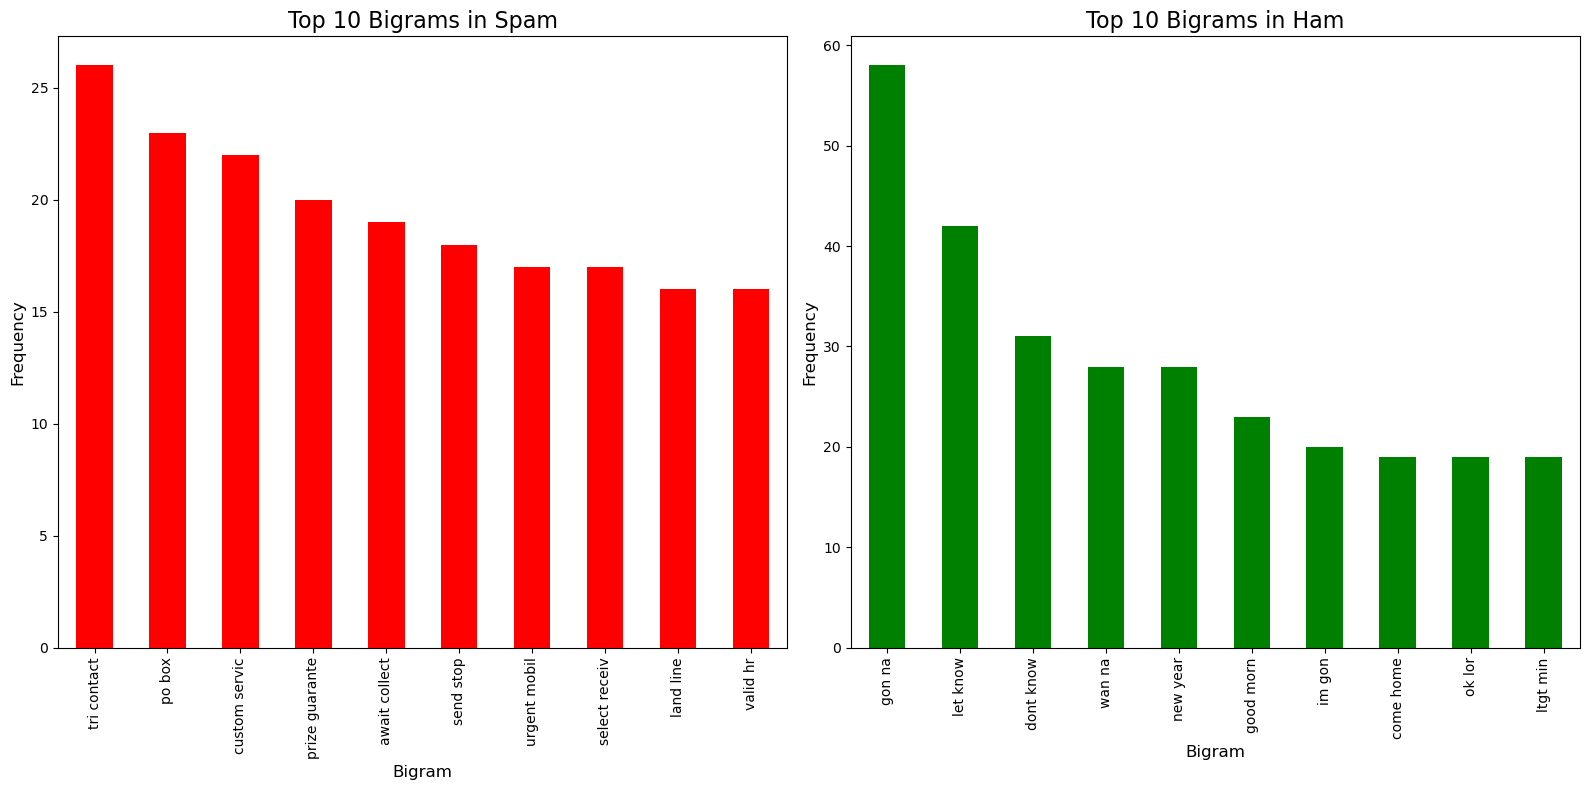

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(corpus, n=10):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(corpus)
    bigrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    bigrams = bigrams.sum(axis=0).sort_values(ascending=False)
    return bigrams.head(n)
spam_bigrams = get_top_bigrams(df[df['target'] == 1]['clean_text'])
ham_bigrams = get_top_bigrams(df[df['target'] == 0]['clean_text'])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
spam_bigrams.plot(kind='bar', color='red', ax=axes[0])
axes[0].set_title('Top 10 Bigrams in Spam', fontsize=16)
axes[0].set_xlabel('Bigram', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

ham_bigrams.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Top 10 Bigrams in Ham', fontsize=16)
axes[1].set_xlabel('Bigram', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

In [150]:
df['clean_text'].apply(type).value_counts()

clean_text
<class 'str'>    5168
Name: count, dtype: int64

<Axes: >

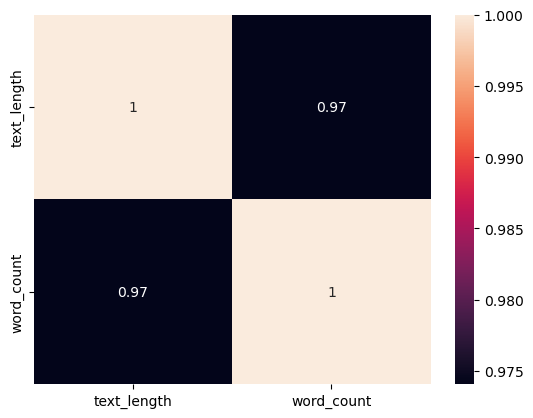

In [132]:
sns.heatmap(df[['text_length', 'word_count']].corr(), annot=True)

In [18]:
df.head()

,target,text,clean_text,text_length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,111,20
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,155,28
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,61,13


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf =TfidfVectorizer(max_features=2000)
cv = CountVectorizer(binary=True)
X = tfidf.fit_transform(df['clean_text'])

In [20]:
X = X.toarray()

In [21]:
df['target'] = df['target'].replace({'spam':1, 'ham':0})

C:\Users\HOME\AppData\Local\Temp\ipykernel_19856\3225293946.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target'] = df['target'].replace({'spam':1, 'ham':0})


In [22]:
y = df['target']

In [23]:
df['target'].value_counts()

target
0    4516
1     652
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

In [26]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = rfc.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("f1-Score: ", f1_score(y_test, y_pred))
print("CM: ", confusion_matrix(y_test, y_pred))

Accuracy:  0.9748549323017408
Precision:  0.9916666666666667
Recall:  0.8263888888888888
f1-Score:  0.9015151515151515
CM:  [[889   1]
 [ 25 119]]


In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier().fit(X_train, y_train)

In [29]:
y_xgb = xgb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_xgb))
print("Precision: ", precision_score(y_test, y_xgb))
print("Recall: ", recall_score(y_test, y_xgb))
print("f1-Score: ", f1_score(y_test, y_xgb))
print("CM: ", confusion_matrix(y_test, y_xgb))

Accuracy:  0.9642166344294004
Precision:  0.9349593495934959
Recall:  0.7986111111111112
f1-Score:  0.8614232209737828
CM:  [[882   8]
 [ 29 115]]


In [30]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, BernoulliNB
gnb = GaussianNB().fit(X_train, y_train)
mnb = MultinomialNB().fit(X_train, y_train)
bnb = BernoulliNB().fit(X_train, y_train)

In [31]:
y_gnb = gnb.predict(X_test)
y_mnb = mnb.predict(X_test)
y_bnb = bnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_gnb))
print("Precision: ", precision_score(y_test, y_gnb))
print("Recall: ", recall_score(y_test, y_gnb))
print("f1-Score: ", f1_score(y_test, y_gnb))
print("CM: ", confusion_matrix(y_test, y_gnb))
print("Accuracy: ", accuracy_score(y_test, y_mnb))
print("Precision: ", precision_score(y_test, y_mnb))
print("Recall: ", recall_score(y_test, y_mnb))
print("f1-Score: ", f1_score(y_test, y_mnb))
print("CM: ", confusion_matrix(y_test, y_mnb))
print("Accuracy: ", accuracy_score(y_test, y_bnb))
print("Precision: ", precision_score(y_test, y_bnb))
print("Recall: ", recall_score(y_test, y_bnb))
print("f1-Score: ", f1_score(y_test, y_bnb))
print("CM: ", confusion_matrix(y_test, y_bnb))

Accuracy:  0.8578336557059961
Precision:  0.49382716049382713
Recall:  0.8333333333333334
f1-Score:  0.6201550387596899
CM:  [[767 123]
 [ 24 120]]
Accuracy:  0.9738878143133463
Precision:  0.9915966386554622
Recall:  0.8194444444444444
f1-Score:  0.8973384030418251
CM:  [[889   1]
 [ 26 118]]
Accuracy:  0.9796905222437138
Precision:  0.9767441860465116
Recall:  0.875
f1-Score:  0.9230769230769231
CM:  [[887   3]
 [ 18 126]]


In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
scores = cross_val_score(bnb, X, y, cv=StratifiedKFold(5), scoring='f1')
print(scores.mean())

0.9077602107537576


In [33]:
from sklearn.model_selection import GridSearchCV
params = {
    "alpha": [0.01,0.1, 0.5, 1.0, 0.7, 0.3],
    "force_alpha": [True, False],
    "binarize": [0.0,0.01],
    "fit_prior": [True, False]
}
grid = GridSearchCV(estimator=bnb,param_grid=params, n_jobs=-1, cv=10, verbose=1,scoring='f1')
grid.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 0.7, 0.3],
                         'binarize': [0.0, 0.01], 'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='f1', verbose=1)

In [34]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.1, 'binarize': 0.0, 'fit_prior': True, 'force_alpha': True}
0.9281536786571267


In [35]:
# param = {'alpha': 0.08435996117994561, 'binarize': 0.06, 'fit_prior': True, 'force_alpha': True} #### best till now
param = {'alpha': 0.1481125757982947, 'binarize': 0.06598616372258259, 'fit_prior': True}
final_model = BernoulliNB(**param).fit(X_train, y_train)
proba = final_model.predict_proba(X_test)[:,1]
thres = 0.45
y_pred_b2 = final_model.predict(X_test)
y_pred_b2 = (proba>=thres).astype(int)
print("Accuracy: ", accuracy_score(y_test, y_pred_b2))
print("Precision: ", precision_score(y_test, y_pred_b2))
print("Recall: ", recall_score(y_test, y_pred_b2))
print("f1-Score: ", f1_score(y_test, y_pred_b2))
print("CM: ", confusion_matrix(y_test, y_pred_b2))

Accuracy:  0.9845261121856866
Precision:  0.9848484848484849
Recall:  0.9027777777777778
f1-Score:  0.9420289855072463
CM:  [[888   2]
 [ 14 130]]


In [36]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
import numpy as np
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 5.0, log=True)  
    binarize = trial.suggest_float("binarize", 0.0, 1.0, step=0.01) 
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])
    force_alpha = trial.suggest_categorical("force_alpha", [True, False])

    model = BernoulliNB(
        alpha=alpha,
        binarize=binarize,
        fit_prior=fit_prior,
        force_alpha=force_alpha
    )

    pipeline = Pipeline([
        ("bnb", model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        pipeline, X_train, y_train,
        scoring=make_scorer(f1_score, average="weighted"),
        cv=cv
    ).mean()
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

print("Best F1 Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-05-09 19:21:36,583] A new study created in memory with name: no-name-2b88cff9-de97-45bf-9c66-1ce3111932ae
[I 2025-05-09 19:21:36,909] Trial 0 finished with value: 0.8196974103018219 and parameters: {'alpha': 3.3409112975993094, 'binarize': 0.86, 'fit_prior': False, 'force_alpha': True}. Best is trial 0 with value: 0.8196974103018219.
[I 2025-05-09 19:21:37,217] Trial 1 finished with value: 0.9762915297774312 and parameters: {'alpha': 6.218425666467592e-05, 'binarize': 0.06, 'fit_prior': True, 'force_alpha': True}. Best is trial 1 with value: 0.9762915297774312.
[I 2025-05-09 19:21:37,596] Trial 2 finished with value: 0.0576733862596611 and parameters: {'alpha': 1.7749071225019845e-05, 'binarize': 0.86, 'fit_prior': False, 'force_alpha': False}. Best is trial 1 with value: 0.9762915297774312.
[I 2025-05-09 19:21:37,901] Trial 3 finished with value: 0.8196974103018219 and parameters: {'alpha': 0.9153605177291386, 'binarize': 0.81, 'fit_prior': False, 'force_alpha': True}. Best is

Best F1 Score: 0.982932889247771
Best Params: {'alpha': 0.08998974217405065, 'binarize': 0.1, 'fit_prior': True, 'force_alpha': True}


In [37]:
from sklearn.ensemble import VotingClassifier
estimators = [("bnb", BernoulliNB(**param)),("mnb",MultinomialNB()),("rfc",rfc)]

In [38]:
voting = VotingClassifier(estimators=estimators, voting='soft', weights=[2,1,3]).fit(X_train, y_train)

In [39]:
proba = final_model.predict_proba(X_test)[:,1]
thres = 0.45
# y_voting = voting.predict(X_test)
y_voting = (proba>=thres).astype(int)
print("Accuracy: ", accuracy_score(y_test, y_voting))
print("Precision: ", precision_score(y_test, y_voting))
print("Recall: ", recall_score(y_test, y_voting))
print("f1-Score: ", f1_score(y_test, y_voting))
print("CM: ", confusion_matrix(y_test, y_voting))

Accuracy:  0.9845261121856866
Precision:  0.9848484848484849
Recall:  0.9027777777777778
f1-Score:  0.9420289855072463
CM:  [[888   2]
 [ 14 130]]


In [40]:
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            voting = voting = VotingClassifier(estimators=estimators, voting='hard', weights=[w1,w2,w3]).fit(X_train, y_train)
            y_voting = voting.predict(X_test)
            print("Current Weights: ",w1,w2,w3)
            print("f1-Score: ", f1_score(y_test, y_voting))

Current Weights:  1 1 1
f1-Score:  0.9333333333333333
Current Weights:  1 1 2
f1-Score:  0.9007633587786259
Current Weights:  1 1 3
f1-Score:  0.9015151515151515
Current Weights:  1 2 1
f1-Score:  0.9007633587786259
Current Weights:  1 2 2
f1-Score:  0.9333333333333333
Current Weights:  1 2 3
f1-Score:  0.9007633587786259
Current Weights:  1 3 1
f1-Score:  0.8973384030418251
Current Weights:  1 3 2
f1-Score:  0.9007633587786259
Current Weights:  1 3 3
f1-Score:  0.9333333333333333
Current Weights:  2 1 1
f1-Score:  0.9333333333333333
Current Weights:  2 1 2
f1-Score:  0.9333333333333333
Current Weights:  2 1 3
f1-Score:  0.9007633587786259
Current Weights:  2 2 1
f1-Score:  0.9333333333333333
Current Weights:  2 2 2
f1-Score:  0.9333333333333333
Current Weights:  2 2 3
f1-Score:  0.9333333333333333
Current Weights:  2 3 1
f1-Score:  0.9007633587786259
Current Weights:  2 3 2
f1-Score:  0.9333333333333333
Current Weights:  2 3 3
f1-Score:  0.9333333333333333
Current Weights:  3 1 1
f1-S

In [41]:
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            voting = voting = VotingClassifier(estimators=estimators, voting='soft', weights=[w1,w2,w3]).fit(X_train, y_train)
            y_voting = voting.predict(X_test)
            print("Current Weights: ",w1,w2,w3)
            print("f1-Score: ", f1_score(y_test, y_voting))

Current Weights:  1 1 1
f1-Score:  0.9338235294117647
Current Weights:  1 1 2
f1-Score:  0.9377289377289377
Current Weights:  1 1 3
f1-Score:  0.929368029739777
Current Weights:  1 2 1
f1-Score:  0.9333333333333333
Current Weights:  1 2 2
f1-Score:  0.9333333333333333
Current Weights:  1 2 3
f1-Score:  0.9333333333333333
Current Weights:  1 3 1
f1-Score:  0.9333333333333333
Current Weights:  1 3 2
f1-Score:  0.929368029739777
Current Weights:  1 3 3
f1-Score:  0.929368029739777
Current Weights:  2 1 1
f1-Score:  0.9377289377289377
Current Weights:  2 1 2
f1-Score:  0.9377289377289377
Current Weights:  2 1 3
f1-Score:  0.9416058394160584
Current Weights:  2 2 1
f1-Score:  0.9338235294117647
Current Weights:  2 2 2
f1-Score:  0.9338235294117647
Current Weights:  2 2 3
f1-Score:  0.9338235294117647
Current Weights:  2 3 1
f1-Score:  0.9372693726937269
Current Weights:  2 3 2
f1-Score:  0.9372693726937269
Current Weights:  2 3 3
f1-Score:  0.9372693726937269
Current Weights:  3 1 1
f1-Scor

In [42]:
y_probs = voting.predict_proba(X_test)[:, 1]

threshold = 0.45
y_pred = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       890
           1       0.99      0.90      0.94       144

    accuracy                           0.98      1034
   macro avg       0.99      0.95      0.97      1034
weighted avg       0.98      0.98      0.98      1034



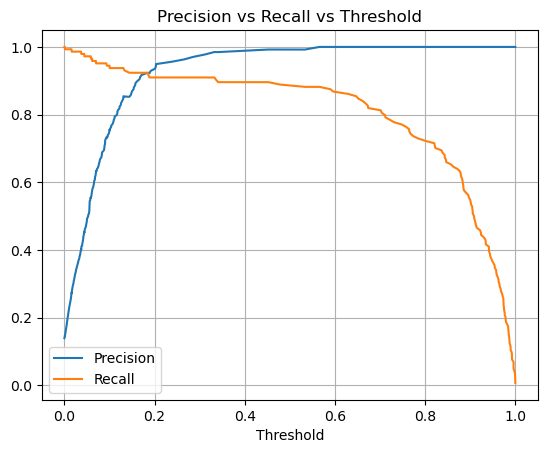

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision vs Recall vs Threshold")
plt.grid()
plt.show()

In [44]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, make_scorer

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 10.0, log=True)  
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])
    force_alpha = trial.suggest_categorical("force_alpha", [True, False])

    model = MultinomialNB(
        alpha=alpha,
        fit_prior=fit_prior,
        force_alpha=force_alpha
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model, X_train, y_train,
        scoring=make_scorer(f1_score, average="weighted"),
        cv=cv,
        n_jobs=-1
    ).mean()

    return score

study = optuna.create_study(direction="maximize",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2))
study.optimize(objective, n_trials=300, show_progress_bar=True)

print("Best F1 Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-05-09 19:28:04,225] A new study created in memory with name: no-name-71eb5a4b-9864-4617-a9ab-3439b03696f2


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-09 19:28:06,701] Trial 0 finished with value: 0.9583887889476456 and parameters: {'alpha': 1.638349653080653, 'fit_prior': True, 'force_alpha': False}. Best is trial 0 with value: 0.9583887889476456.
[I 2025-05-09 19:28:08,245] Trial 1 finished with value: 0.9567837117253871 and parameters: {'alpha': 0.03854109876236682, 'fit_prior': False, 'force_alpha': False}. Best is trial 0 with value: 0.9583887889476456.
[I 2025-05-09 19:28:09,404] Trial 2 finished with value: 0.954856218001024 and parameters: {'alpha': 7.156586611243994e-05, 'fit_prior': False, 'force_alpha': False}. Best is trial 0 with value: 0.9583887889476456.
[I 2025-05-09 19:28:09,794] Trial 3 finished with value: 0.9713799596807746 and parameters: {'alpha': 0.002059844357191223, 'fit_prior': True, 'force_alpha': True}. Best is trial 3 with value: 0.9713799596807746.
[I 2025-05-09 19:28:10,048] Trial 4 finished with value: 0.9721322875182823 and parameters: {'alpha': 0.003754768950589996, 'fit_prior': True, 'for

In [45]:
params_mnb = {'alpha': 0.11296477048132918, 'fit_prior': True, 'force_alpha': False}
mnb = MultinomialNB(**params_mnb).fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_mnb))
print("Precision: ", precision_score(y_test, y_mnb))
print("Recall: ", recall_score(y_test, y_mnb))
print("f1-Score: ", f1_score(y_test, y_mnb))
print("CM: ", confusion_matrix(y_test, y_mnb))

Accuracy:  0.9816247582205029
Precision:  0.9844961240310077
Recall:  0.8819444444444444
f1-Score:  0.9304029304029304
CM:  [[888   2]
 [ 17 127]]


In [46]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 400, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 30, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model, X_train, y_train,
        scoring=make_scorer(f1_score, average="weighted"),
        cv=cv,
        n_jobs=-1
    ).mean()

    return score

study = optuna.create_study(direction="maximize", 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best F1 Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-05-09 19:29:35,784] A new study created in memory with name: no-name-a98e10b5-2ecc-423f-9520-6f9fe81d02f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-09 19:29:38,394] Trial 0 finished with value: 0.8818958683986595 and parameters: {'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8818958683986595.
[I 2025-05-09 19:29:48,913] Trial 1 finished with value: 0.953891933419917 and parameters: {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.953891933419917.
[I 2025-05-09 19:29:51,069] Trial 2 finished with value: 0.8985142815136065 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.953891933419917.
[I 2025-05-09 19:29:57,040] Trial 3 finished with value: 0.8911185781023656 and parameters: {'n_estimators': 350, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features':

In [100]:
estimators = [("bnb", BernoulliNB(**param)),("mnb",MultinomialNB(**params_mnb)),("rfc",rfc)]
voting = VotingClassifier(estimators=estimators).fit(X_train, y_train)
y_voting = voting.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_voting))
print("Precision: ", precision_score(y_test, y_voting))
print("Recall: ", recall_score(y_test, y_voting))
print("f1-Score: ", f1_score(y_test, y_voting))
print("CM: ", confusion_matrix(y_test, y_voting))

Accuracy:  0.9845261121856866
Precision:  1.0
Recall:  0.8888888888888888
f1-Score:  0.9411764705882353
CM:  [[890   0]
 [ 16 128]]


In [48]:
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            voting = voting = VotingClassifier(estimators=estimators, voting='soft', weights=[w1,w2,w3]).fit(X_train, y_train)
            y_voting = voting.predict(X_test)
            print("Current Weights: ",w1,w2,w3)
            print("f1-Score: ", f1_score(y_test, y_voting))

Current Weights:  1 1 1
f1-Score:  0.9377289377289377
Current Weights:  1 1 2
f1-Score:  0.9377289377289377
Current Weights:  1 1 3
f1-Score:  0.9377289377289377
Current Weights:  1 2 1
f1-Score:  0.9377289377289377
Current Weights:  1 2 2
f1-Score:  0.9411764705882353
Current Weights:  1 2 3
f1-Score:  0.9411764705882353
Current Weights:  1 3 1
f1-Score:  0.9411764705882353
Current Weights:  1 3 2
f1-Score:  0.9411764705882353
Current Weights:  1 3 3
f1-Score:  0.9411764705882353
Current Weights:  2 1 1
f1-Score:  0.9377289377289377
Current Weights:  2 1 2
f1-Score:  0.9416058394160584
Current Weights:  2 1 3
f1-Score:  0.9416058394160584
Current Weights:  2 2 1
f1-Score:  0.9377289377289377
Current Weights:  2 2 2
f1-Score:  0.9377289377289377
Current Weights:  2 2 3
f1-Score:  0.9377289377289377
Current Weights:  2 3 1
f1-Score:  0.9338235294117647
Current Weights:  2 3 2
f1-Score:  0.9377289377289377
Current Weights:  2 3 3
f1-Score:  0.9377289377289377
Current Weights:  3 1 1
f1-S

In [168]:
import joblib

In [170]:
joblib.dump(voting, "Spam_detection_voting.pkl")

['Spam_detection_voting.pkl']

In [172]:
joblib.dump(tfidf, "tfidf_spam_voting.pkl")

['tfidf_spam_voting.pkl']